In [24]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.holtwinters import ExponentialSmoothing
np.random.seed(0) # For reproducibility

import numpy as np
from scipy.fft import fft

def fft_analysis(signal):
    
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    
    return dominant_period, positive_frequencies, magnitudes
import matplotlib.pyplot as plt

def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    """
    Plot the time series data

    Parameters
    ----------
    x : array-like
        The time values.
    y : array-like
        The values of the time series.
    title : str
        The title of the plot.
    xlabel : str
        The label for the x-axis.
    ylabel : str
        The label for the y-axis.
    ax : matplotlib axes
        The axes to plot on.

    Returns
    -------
    ax : matplotlib axes
        The axes object with the plot.
    """
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax



In [25]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts3.npz?download=1")
response.raise_for_status()
arma_ts1 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts4.npz?download=1")
response.raise_for_status()
arma_ts2 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts2))

time1 = np.arange(len(arma_ts1))
time2 = np.arange(len(arma_ts2))

479
1000


## EXERCISES

For each time series:

1. Split the time series in train and test.
    - Use the last 30 values as test for the first time series.
    - Use the last 100 as test for the second time series.
2. Make the time series stationary.
3. Determine the order $p$ of an AR model.
4. Compute the prediction of the test data with the AR($p$) model.
5. Determine the order $q$ of a MA model.
6. Compute the prediction of the test data with the MA($q$) model.

### points 1 + 2

To make the TS stationary, first find the period of both using FFT on the test set.

Dominant Frequency: 0.082
Dominant Period: 12.14 time units


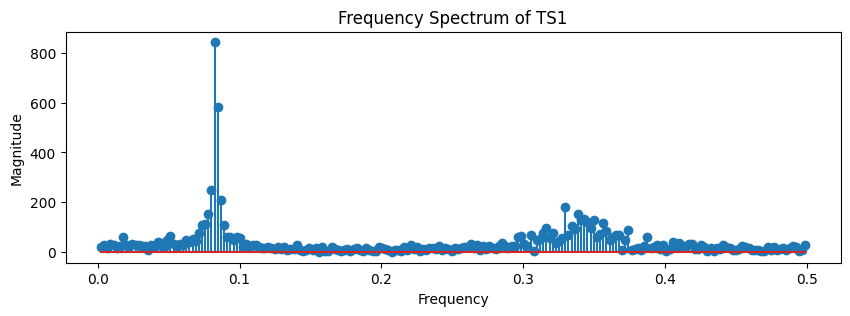

Dominant Frequency: 0.042
Dominant Period: 23.68 time units


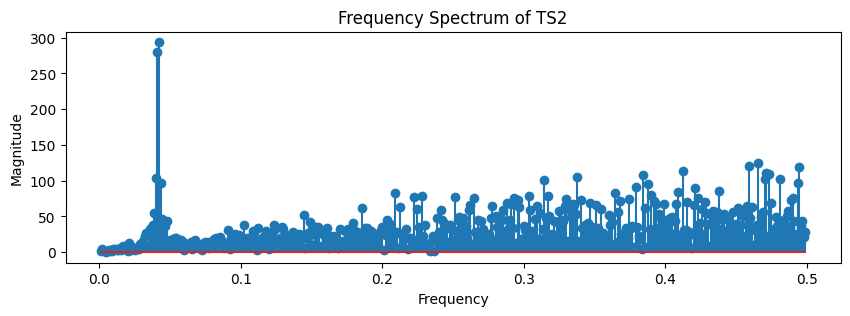

In [26]:
train_1 = arma_ts1[:449]
test_1 = arma_ts1[449:]

train_2 = arma_ts2[:900]
test_2 = arma_ts2[900:]


period, freqs, magnitudes = fft_analysis(train_1)
# Plotting the spectrum
plt.figure(figsize=(10, 3))
plt.stem(freqs, magnitudes)
plt.title('Frequency Spectrum of TS1')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

period, freqs, magnitudes = fft_analysis(train_2)
# Plotting the spectrum
plt.figure(figsize=(10, 3))
plt.stem(freqs, magnitudes)
plt.title('Frequency Spectrum of TS2')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


Now use triple exponential smoothing to remove seasonal component and trend on both TS, using a period of 12 and 24. 

p-value TS1: 0.000
p-value TS2: 0.000


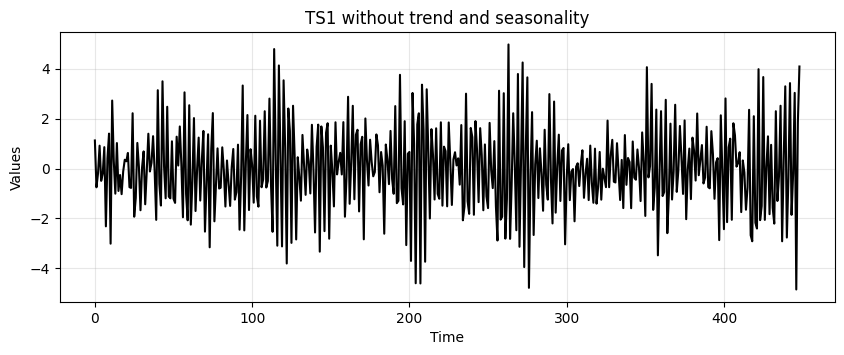

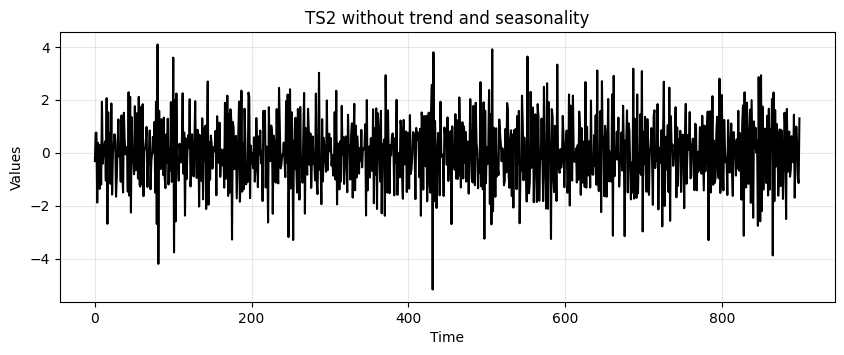

In [27]:
tes_1 = ExponentialSmoothing(train_1, trend='add',
                           seasonal='add', seasonal_periods=12).fit()
trend_and_seasonality_1 = tes_1.fittedvalues # Estimated trend and seasonality
train_1_resid = train_1 - trend_and_seasonality_1

_, pvalue_1, _, _, _, _ = adfuller(train_1_resid)
print(f"p-value TS1: {pvalue_1:.3f}")

tes_2 = ExponentialSmoothing(train_2, trend='add',
                           seasonal='add', seasonal_periods=24).fit()
trend_and_seasonality_2 = tes_2.fittedvalues # Estimated trend and seasonality
train_2_resid = train_2 - trend_and_seasonality_2

_, pvalue_2, _, _, _, _ = adfuller(train_2_resid)
print(f"p-value TS2: {pvalue_2:.3f}")

run_sequence_plot(np.arange(len(train_1_resid)), train_1_resid, "TS1 without trend and seasonality")
run_sequence_plot(np.arange(len(train_2_resid)), train_2_resid, "TS2 without trend and seasonality")

diff_ts2 = np.diff(train_2_resid, n=1)


The null hypotesys is rejected for both TS, even though TS1 still retains some seasonal components.

### POINTS 3 + 4

To check model order of the AR model, lets look at the PACF of the two stationary TS.

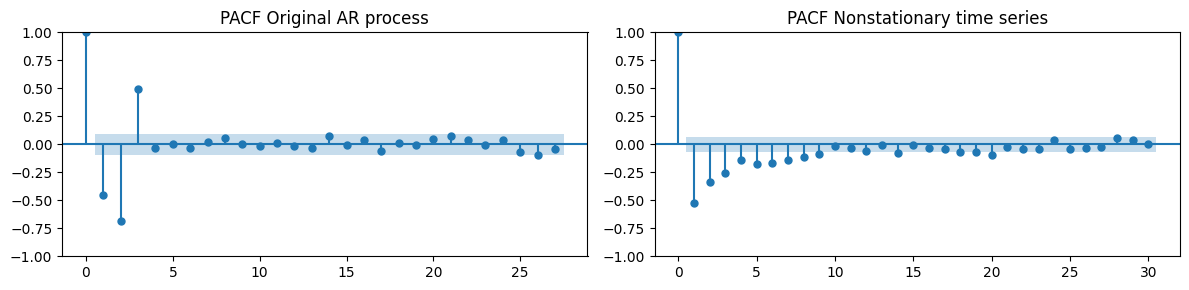

In [28]:
_, axes = plt.subplots(1, 2, figsize=(12, 3))
plot_pacf(train_1_resid, ax=axes[0], title="PACF Original AR process")
plot_pacf(train_2_resid, ax=axes[1], title="PACF Nonstationary time series")
plt.tight_layout();

- The for TS1, the PACF clearly shows a cut off of PACF function at lag 3. This means that an AR model can probably well explain the TS. The order of the AR model is 3.
- For TS2, the PACF does not show a clear cutoff. This means that maybe an AR model is not the most suitable for the problem at hand. 

In any case, even though several spikes seems relevant, I would not consider a model order higher than 4 to aoid overfitting.

MSE for TS1 obtained with an AR(3) model: 2.16
MSE for TS2 obtained with an AR(4) model: 1.68


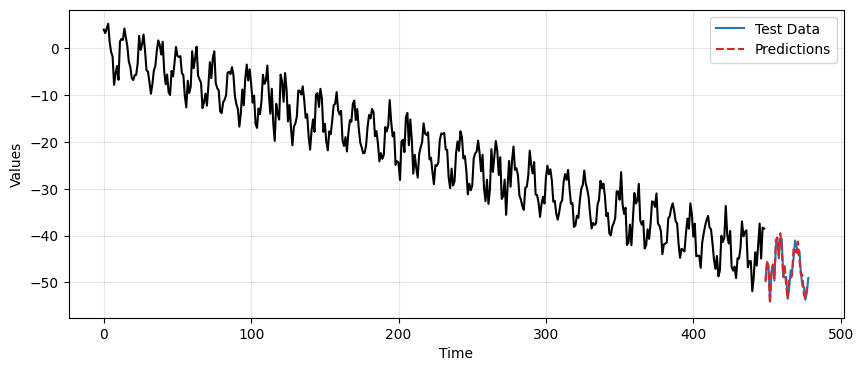

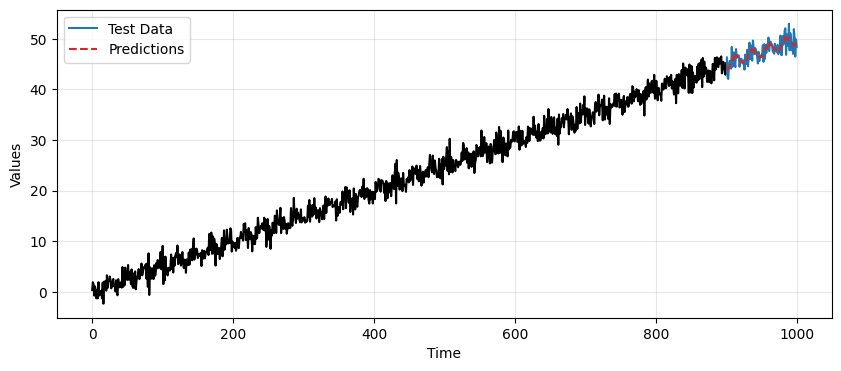

In [29]:
#TS1
ar_1 = ARIMA(train_1_resid, order=(3,0,0))
ar_1_fit = ar_1.fit()

ar_1_preds = ar_1_fit.forecast(steps=len(test_1))
tes_pred1 = tes_1.forecast(steps=len(test_1))
full_ar1_preds = ar_1_preds + tes_pred1

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time1[:len(train_1)], train_1, "", ax=ax)
ax.plot(time1[len(train_1):], test_1, label='Test Data', color='tab:blue')
ax.plot(time1[len(train_1):], full_ar1_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

# TS2
ar_2 = ARIMA(train_2_resid, order=(4,0,0))
ar_2_fit = ar_2.fit()

ar_2_preds = ar_2_fit.forecast(steps=len(test_2))
tes_pred2 = tes_2.forecast(steps=len(test_2))
full_ar2_preds = ar_2_preds + tes_pred2

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time2[:len(train_2)], train_2, "", ax=ax)
ax.plot(time2[len(train_2):], test_2, label='Test Data', color='tab:blue')
ax.plot(time2[len(train_2):], full_ar2_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

mse_ar1 = mean_squared_error(test_1, full_ar1_preds)
mse_ar2 = mean_squared_error(test_2, full_ar2_preds)

print(f"MSE for TS1 obtained with an AR(3) model: {mse_ar1:.2f}")
print(f"MSE for TS2 obtained with an AR(4) model: {mse_ar2:.2f}")

### POINTS 5 + 6

To check model order of the AR model, lets look at the ACF of the two stationary TS.

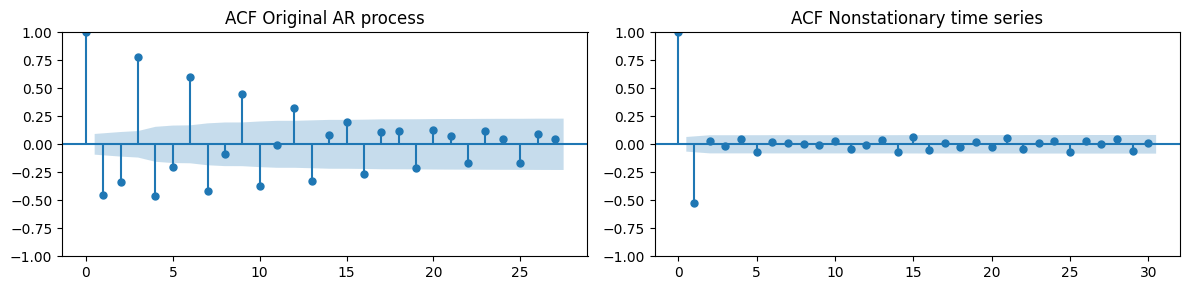

In [30]:
_, axes = plt.subplots(1, 2, figsize=(12, 3))
plot_acf(train_1_resid, ax=axes[0], title="ACF Original AR process")
plot_acf(train_2_resid, ax=axes[1], title="ACF Nonstationary time series")
plt.tight_layout();

- For TS1, the ACF presents several spikes probably due to spurious correlation between samples, taken into account in ACF but not PACF. 

A clear decision for the MA model is not easy, I woul consider not more than order 2 to avoid overfitting.
- For TS2, the ACF shows a clear cur off at lag 1. MA is probably suited to model this TS. The order will be 1.

MSE for TS1 obtained with an MA(2) model: 3.74
MSE for TS2 obtained with an MA(1) model: 1.69


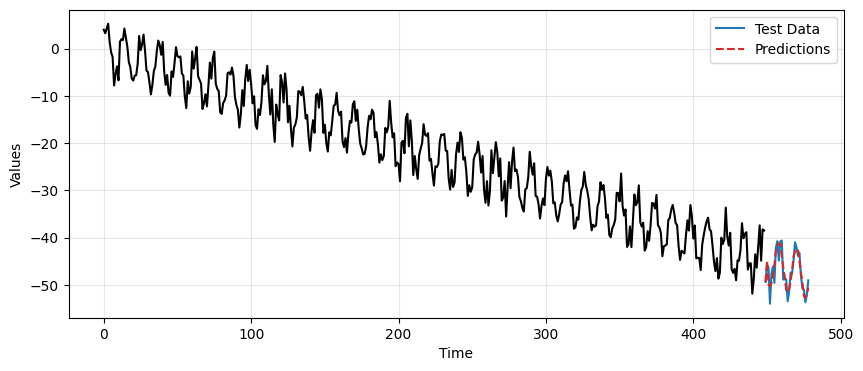

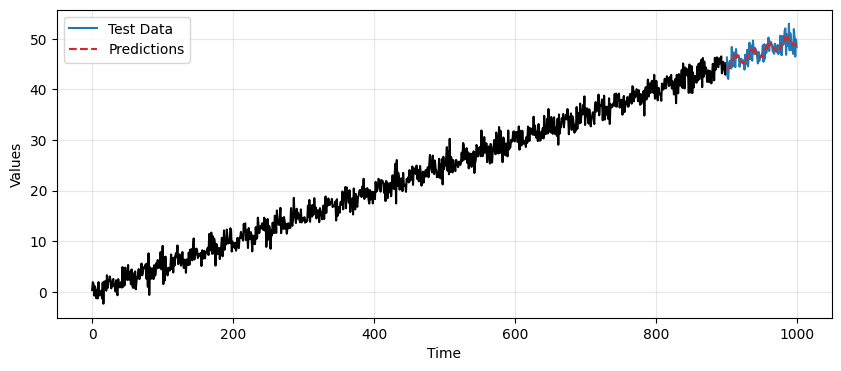

In [31]:
#TS1
ma_1 = ARIMA(train_1_resid, order=(0,0,2))
ma_1_fit = ma_1.fit()

ma_1_preds = ma_1_fit.forecast(steps=len(test_1))
tes_pred1 = tes_1.forecast(steps=len(test_1))
full_ma1_preds = ma_1_preds + tes_pred1

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time1[:len(train_1)], train_1, "", ax=ax)
ax.plot(time1[len(train_1):], test_1, label='Test Data', color='tab:blue')
ax.plot(time1[len(train_1):], full_ma1_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

# TS2
ma_2 = ARIMA(train_2_resid, order=(0,0,1))
ma_2_fit = ma_2.fit()

ma_2_preds = ma_2_fit.forecast(steps=len(test_2))
tes_pred2 = tes_2.forecast(steps=len(test_2))
full_ma2_preds = ma_2_preds + tes_pred2

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time2[:len(train_2)], train_2, "", ax=ax)
ax.plot(time2[len(train_2):], test_2, label='Test Data', color='tab:blue')
ax.plot(time2[len(train_2):], full_ma2_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

mse_ma1 = mean_squared_error(test_1, full_ma1_preds)
mse_ma2 = mean_squared_error(test_2, full_ma2_preds)

print(f"MSE for TS1 obtained with an MA(2) model: {mse_ma1:.2f}")
print(f"MSE for TS2 obtained with an MA(1) model: {mse_ma2:.2f}")

- The forecasting MSE for TS1 increases when using an MA model instead of AR. 

This is somewhat expected by looking at the PACF and ACF of the TS, that displays a hard cutoff in the PACF but not ACF.

- For TS2, surprisingly, the forecasting MSE between the AR and MA model is the same.